# <span style='color:darkorchid'> Developing a machine learning model for classifying on Tik Tok </span>

## Project Overview

TikTok, a leading platform for short-form mobile video, aims to foster inclusive, joyful, and authentic content creation. The data team focuses on increasing opinion videos, vital for platform growth. Observing that verified users are more likely to post opinions, the team aims to predict verified status based on video characteristics. This project involves developing a machine-learning model to classify videos as claims or opinions.
 We addressed skewed data, class imbalance & multicollinearity. The model achieved 74% precision.

<br> This project has 4 parts:
* Business Problem
* Data Understanding
* Modeling and Evaluation
* Conclusion


<img src="images/problem_10266358.png" width="100" height="100" align=left  >
 
## Part 1: Business Problem

The objective is to build a logistic regression model predicting whether a video is a claim or an opinion, using verified status as the outcome variable. This model will aid in prioritizing user reports efficiently and reducing backlog. Key questions include understanding the variables associated with user verification.

<img src="images/survey_10266430.png" width="100" height="100" align=left  >


## Part 2: Data Undrestanding

<br>
<br> 1. Descriptive analysis, hypothesis testing, and correlation matrices were used during exploratory data analysis.
<br> 2. Outliers were identified using interquartile range (IQR) and median due to strong skewness in certain variables.
<br> 3. Data preparation involved transforming categorical variables into numeric using one-hot encoding. 
<br> 4. Logistic regression assumptions were checked, including balanced classes and multicollinearity. 
<br> 5. To address class imbalance, upsampling was performed, and multicollinearity was resolved by removing one variable. 

In [1]:
# import libraries and load data

## packages for data manipulation
import pandas as pd
import numpy as np

## packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## packages for statistical test
import scipy.stats as stats


# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

data = pd.read_csv("tiktok_dataset.csv")

data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0




### <span style='color:darkorchid'> In table below, we can see: </span>

* the distribution of views, likes, shares, and comments likely follows a skewed distribution, with a longer tail towards the higher values. **Because mean is higher than median**.
* This is because a small number of videos might have an exceptionally high number of views or interactions.
* So, we need to see visualizations like histograms or boxplots to get a better sense of the data distribution for each metric.


In [2]:
#data.shape
#data.info()
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000




### <span style='color:darkorchid'> Based on correlation matrix below: </span>

* the number of video views is a strong predictor of the number of likes a video receives. Videos with more views tend to get more likes which is natural but **this relationship is not linear**.

* There is a positive correlation between views and comments and views and shares, but these relationships are weaker.

* The number of comments and shares appears to be unrelated.


### <span style='color:navy'> Correlation doesn't equal causation. Just because views and likes are correlated doesn't mean more views cause more likes. It could be that more engaging videos get both more views and likes. </span>




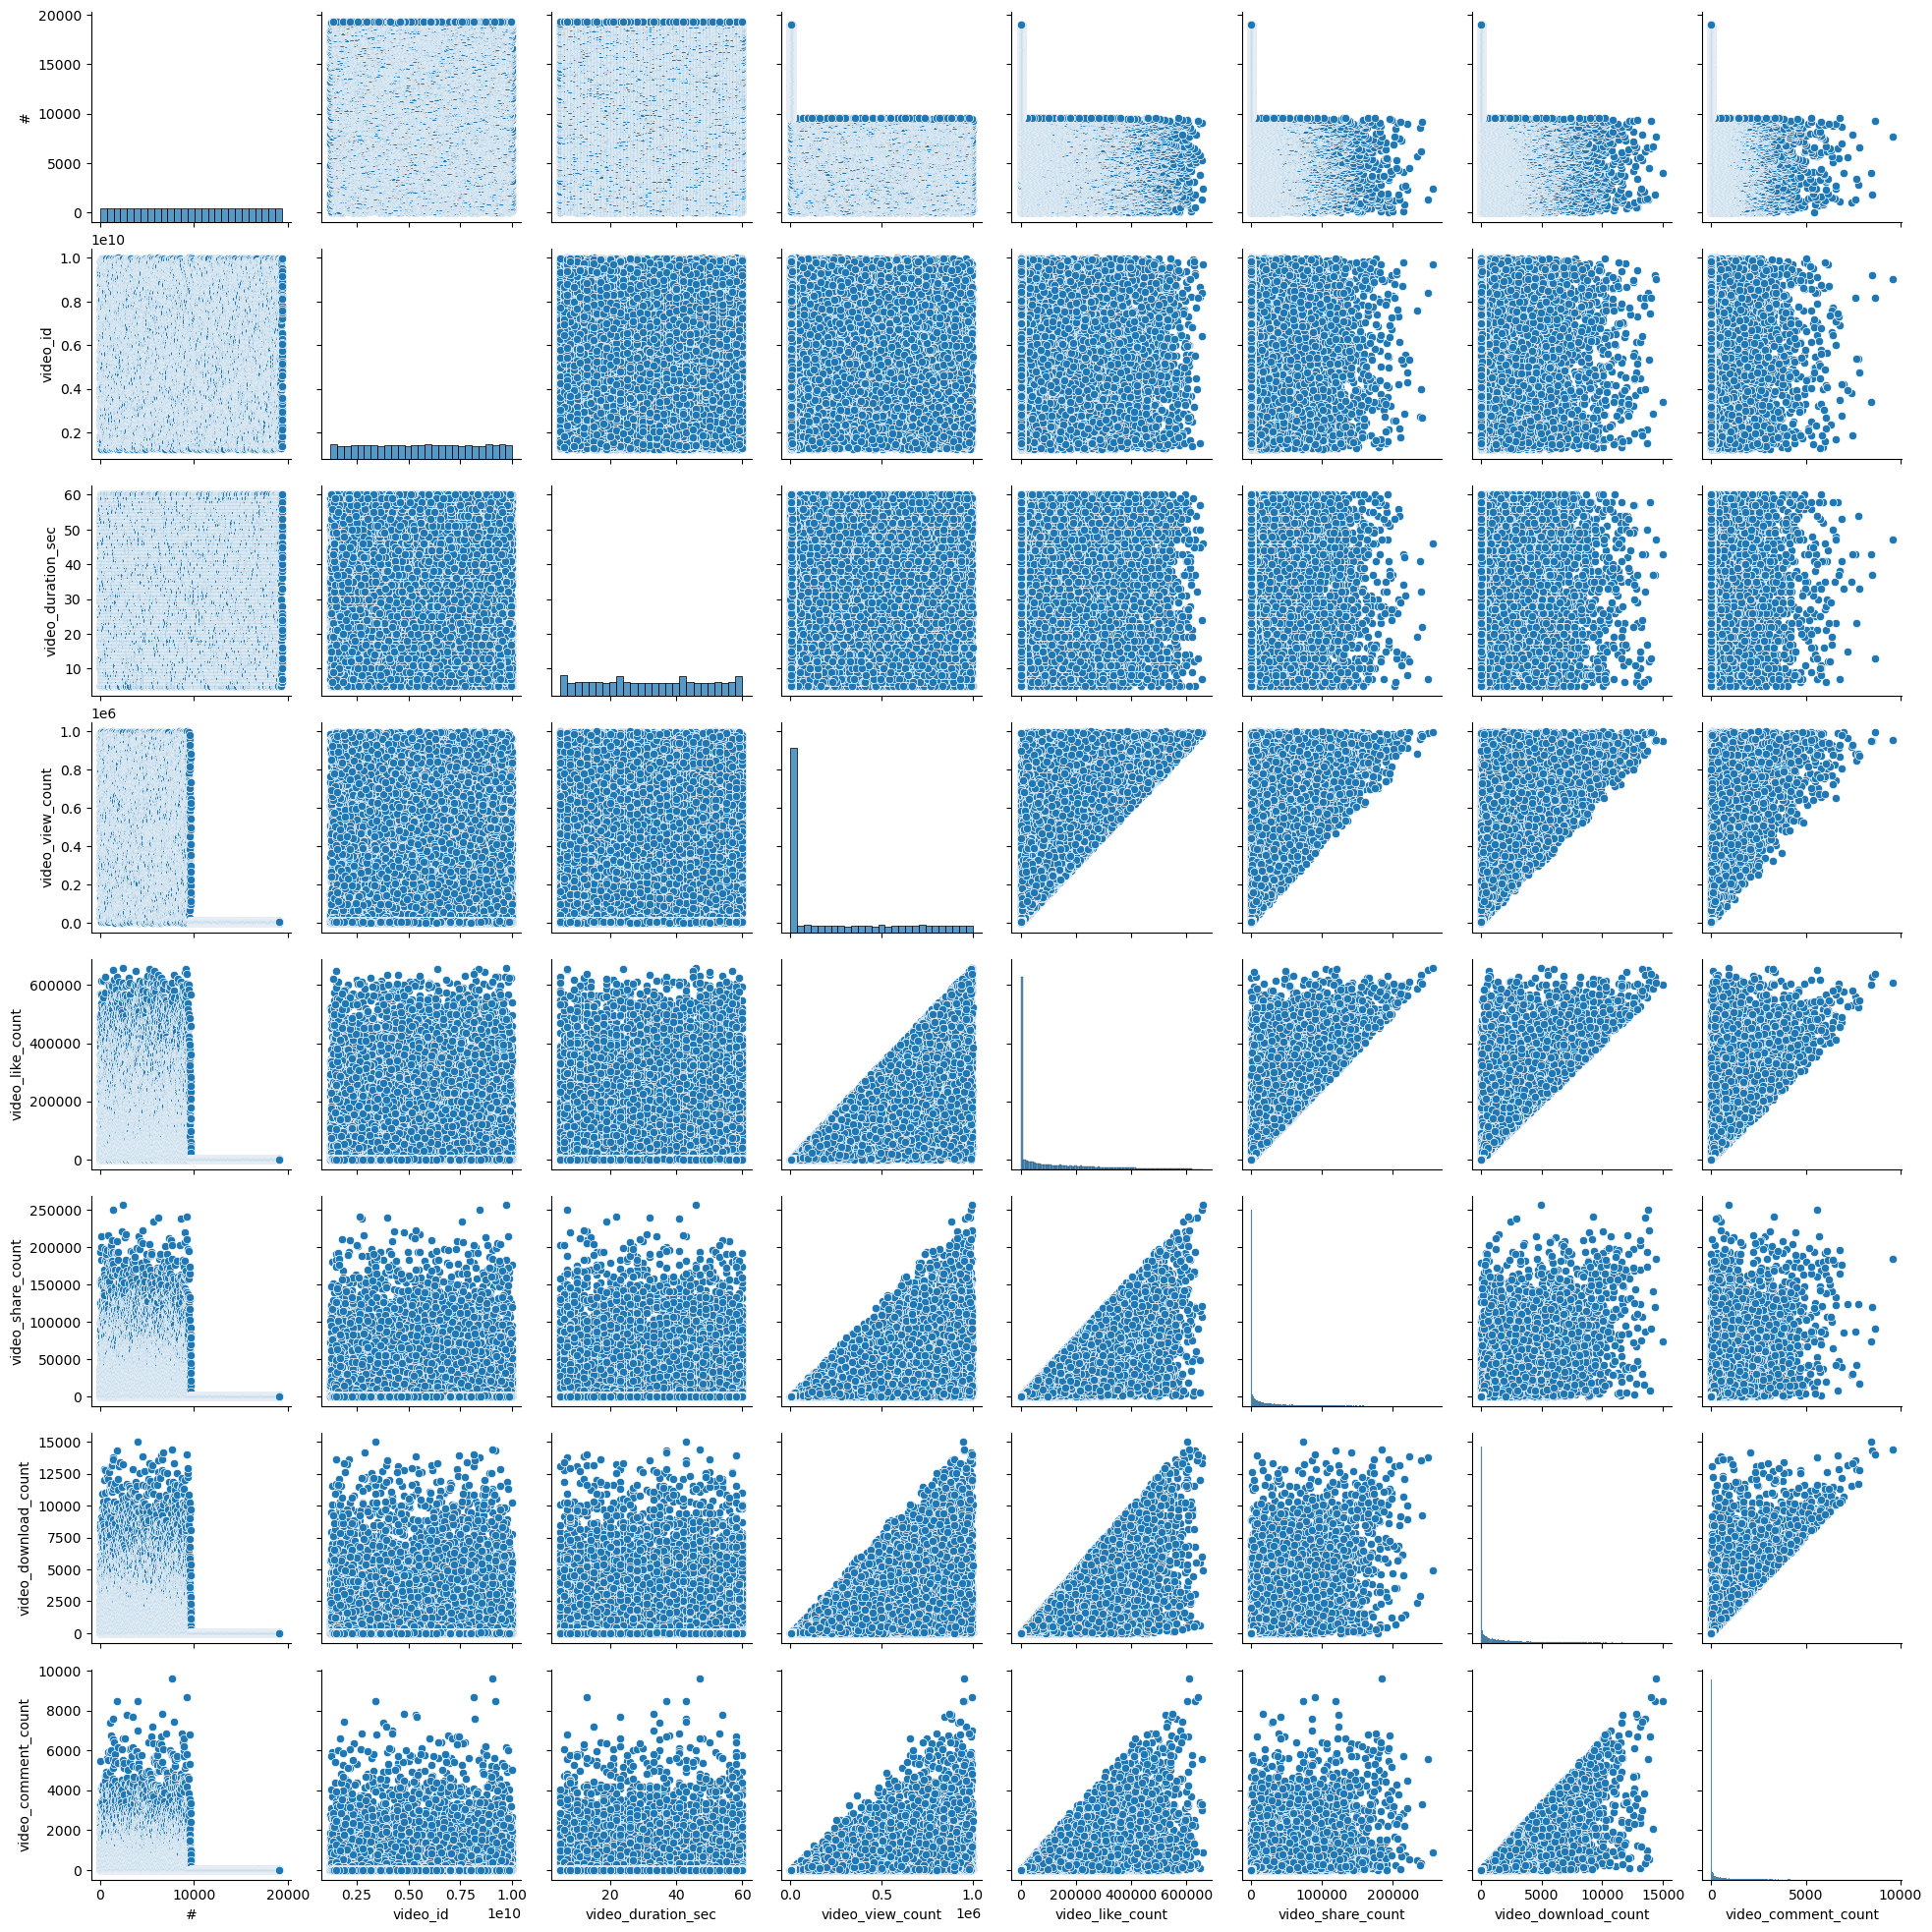

In [3]:
# correlogram matrix
sns.pairplot(data)
plt.show()

In [4]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/nw/7766myvd65gfypd6nd1lgsb40000gn/T/ipykernel_4009/4136402251.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()
/var/folders/nw/7766myvd65gfypd6nd1lgsb40000gn/T/ipykernel_4009/4136402251.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
#,1.00,-0.00,-0.00,-0.67,-0.54,-0.45,-0.45,-0.38
video_id,-0.00,1.00,0.01,0.00,0.00,-0.00,0.00,0.01
video_duration_sec,-0.00,0.01,1.00,0.01,0.01,0.01,0.01,0.00
video_view_count,-0.67,0.00,0.01,1.00,0.80,0.67,0.66,0.55
video_like_count,-0.54,0.00,0.01,0.80,1.00,0.83,0.82,0.69
video_share_count,-0.45,-0.00,0.01,0.67,0.83,1.00,0.68,0.57
video_download_count,-0.45,0.00,0.01,0.66,0.82,0.68,1.00,0.83
video_comment_count,-0.38,0.01,0.00,0.55,0.69,0.57,0.83,1.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


### <span style='color:darkorchid'> From box plots we can conclude that: </span>
1.  IQR for video duration is between 20 and 40 seconds. This means that half of the videos fall within this range.
2.  For views and likes, the median and Q1 are very close to min. It indicate that, a large portion of the data falls close to the lowest value.
3. For comments, the majority of videos have fewer comments. Since the platform is TikTok it could be normal (people don't tend to leave comment on TikTok). 



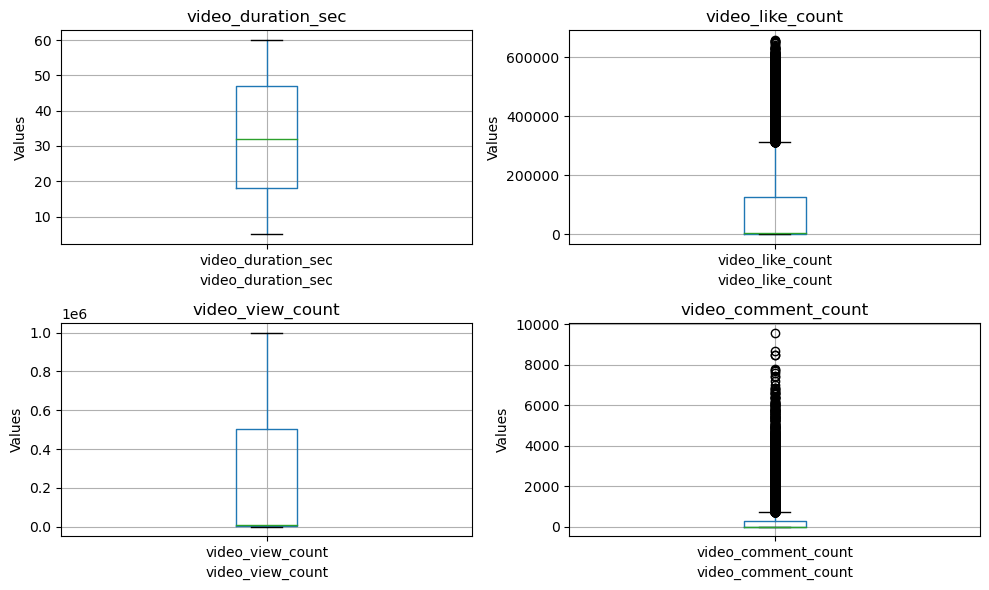

In [6]:
# boxplot for visulize distribution

columns_to_plot = ["video_duration_sec", "video_like_count", "video_view_count", "video_comment_count"]

plt.figure(figsize=(10,6))


for i, col in enumerate(columns_to_plot):
    plt.subplot(2,2, i+1)
    data.boxplot(column=col)
    plt.title(col)  
    plt.xlabel(col)
    plt.ylabel('Values')
    

plt.tight_layout()
plt.show()

### <span style='color:darkorchid'> Further research: </span>

<br> There are significantly more unverified profiles on TikTok compared to verified profiles.
<br> It might be difficault to get verified on Tik Tok. we can investigate what factors influence TikTok's verification process in next projects.

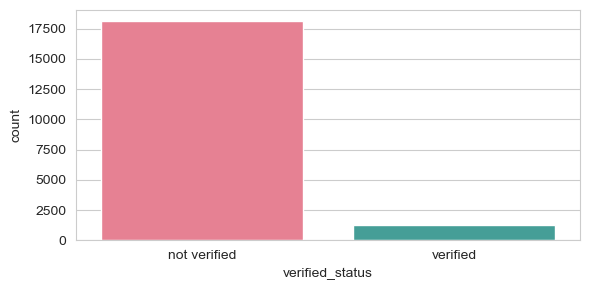

In [7]:
#  checking the breakdown of “author ban status” counts.

plt.figure(figsize=(6,3))
sns.set_style("whitegrid")
sns.countplot(data = data, x = 'verified_status', palette = 'husl')
plt.tight_layout()
plt.show()

### <span style= 'color:red' > Curiosity: </span>
* For both claims and opinions, there are many more active authors than banned authors or authors under review; however, the proportion of active authors is far greater for opinion videos than for claim videos. Again, it seems that authors who post claim videos are more likely to come under review and/or get banned.

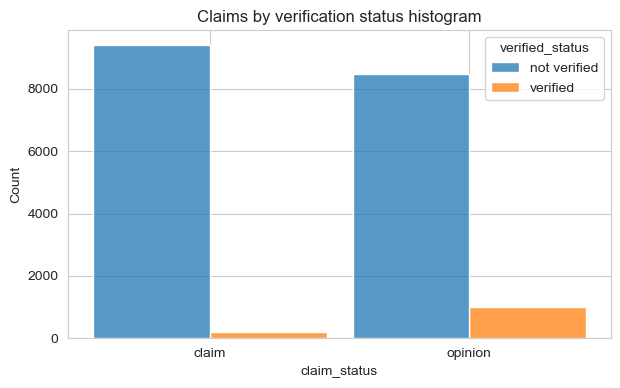

In [8]:
plt.figure(figsize=(7,4))

sns.histplot(data=data,
             x='claim_status',
             hue='verified_status',
             multiple='dodge',
             shrink=0.9)
plt.title('Claims by verification status histogram');

plt.show()

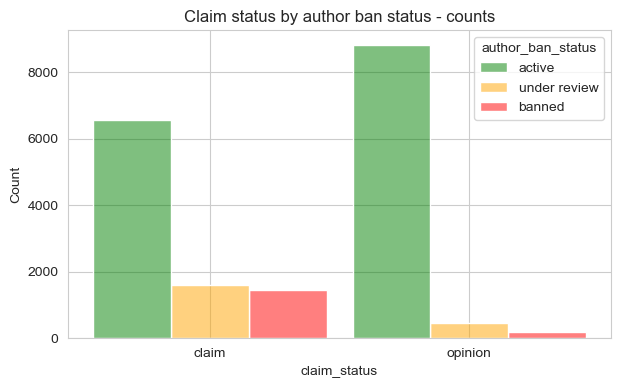

In [9]:
fig = plt.figure(figsize=(7,4))
sns.histplot(data, x='claim_status', hue='author_ban_status',
             multiple='dodge',
             hue_order=['active', 'under review', 'banned'],
             shrink=0.9,
             palette={'active':'green', 'under review':'orange', 'banned':'red'},
             alpha=0.5)
plt.title('Claim status by author ban status - counts');
plt.show()

In [10]:
# outliers

count_cols = ['video_view_count',
              'video_like_count',
              'video_share_count',
              'video_download_count',
              'video_comment_count',
              ]

for column in count_cols:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    median = data[column].median()
    outlier_threshold = median + 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = (data[column] > outlier_threshold).sum()
    print(f'Number of outliers, {column}:', outlier_count)

Number of outliers, video_view_count: 2343
Number of outliers, video_like_count: 3468
Number of outliers, video_share_count: 3732
Number of outliers, video_download_count: 3733
Number of outliers, video_comment_count: 3882




### <span style= 'color:red' > Curiosity: </span>
* Lets see is there any information related to what distinguishes claim videos from opinion videos?

1. It seems, the average views,like and share for claim videos are much higher than opinion videos. Is this statistically significant? 
2. We conduct a hypothesis test with p-value of 5%.
3. $H0$ : there is no meaning full difference between views of claim and opinion video.<br> $H1$ : there is meaning full difference between views of claim and opinion video.
4. The p-value in 0%. We conclude that there is a statistically significant difference between the mean.

In [11]:
data["claim_status"].value_counts()

claim      9608
opinion    9476
Name: claim_status, dtype: int64

In [12]:
claim_status = data.groupby(["claim_status"]).agg({'video_view_count' : 'mean',
                                                  'video_like_count': 'mean',
                                                  'video_id': 'count',
                                                  'video_duration_sec':'mean',
                                                  'video_share_count':'mean'})
claim_status

,video_view_count,video_like_count,video_id,video_duration_sec,video_share_count
claim_status,,,,,
claim,501029.452748,166373.331182,9608,32.486886,33026.416216
opinion,4956.432250,1092.729844,9476,32.359856,217.145631


In [13]:
# conduct a hypothesis test

claim = data[data["claim_status"] == "claim"]
opinion = data[data["claim_status"] == "opinion"]

# compute the mean
print(claim["video_view_count"].mean().round())
print(opinion["video_view_count"].mean().round())



# Find the P-value
stats.ttest_ind(a= claim.dropna()["video_view_count"]  ,b= opinion.dropna()["video_view_count"] ,
                equal_var=False)

501029.0
4956.0


Ttest_indResult(statistic=166.88857822856752, pvalue=0.0)

<img src="images/creative-writing_10266412.png" width="100" height="100" align=left  >


## Part 3: Modeling and Evaluation

* The model evaluation showed higher performance in predicting the "not verified" class.
* Precision: How many of the predicted positives were actually correct? (74% for "verified" class)
* Recall: How many of the actual positives did the model capture? (82% for "not verified" class)
* F1-score: Harmonic mean of precision and recall, a balanced measure. (71% for "not verified" class)




## <span style='color:navy' >  data preparation: </span>




In [14]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [15]:
# drop rows with missing values
data_1 = data.dropna(axis=0)

In [16]:
# checking for duplicate
data.duplicated().sum()

0

In [17]:
# dealing with outliers

## In the EDA part we saw only for like and comment there is a strong skew to the right.
## here we exclude outliers from them.

#like
percentile25_like = data_1["video_like_count"].quantile(0.25)
percentile75_like = data_1["video_like_count"].quantile(0.75)

iqr = percentile75_like -percentile25_like
upper_limit = percentile75_like + 1.5*iqr

data_1.loc[data_1["video_like_count"] > upper_limit , "video_like_count"] = upper_limit


#comment
percentile25_comment = data_1["video_comment_count"].quantile(0.25)
percentile75_comment = data_1["video_comment_count"].quantile(0.75)
iqr = percentile75_comment - percentile25_comment
upper_limit = percentile75_comment + 1.5* iqr

data_1.loc[data_1["video_comment_count"] > upper_limit, "video_comment_count" ] = upper_limit

### <span style= 'color:red' > Assumption one for logestic regression: balanced classes </span>
Based on information below,
* Almost 94% of videos are posted by not verified account.
* So we deal with unbalanced class and need to do resampling.

In [18]:
# check balance class

data_1["verified_status"].value_counts(normalize=True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

In [19]:
# resampling
majority = data_1[data_1["verified_status"] == "not verified"]
minority = data_1[data_1["verified_status"] == "verified"]

data_minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=0 )

data_upsampled = pd.concat([majority , data_minority_upsampled]).reset_index(drop=True)

data_upsampled["verified_status"].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

### <span style= 'color:red' > Assumption two for logestic regression: no multicollinearity among the features </span>

* The below heatmap shows that the following pair of variables are strongly correlated: video_view_count and video_like_count.
* To build a logistic regression model that meets this assumption, we could exclude video_like_count. And among the variables that quantify video metrics, we could keep video_view_count, video_share_count, video_download_count, and video_comment_count as features.


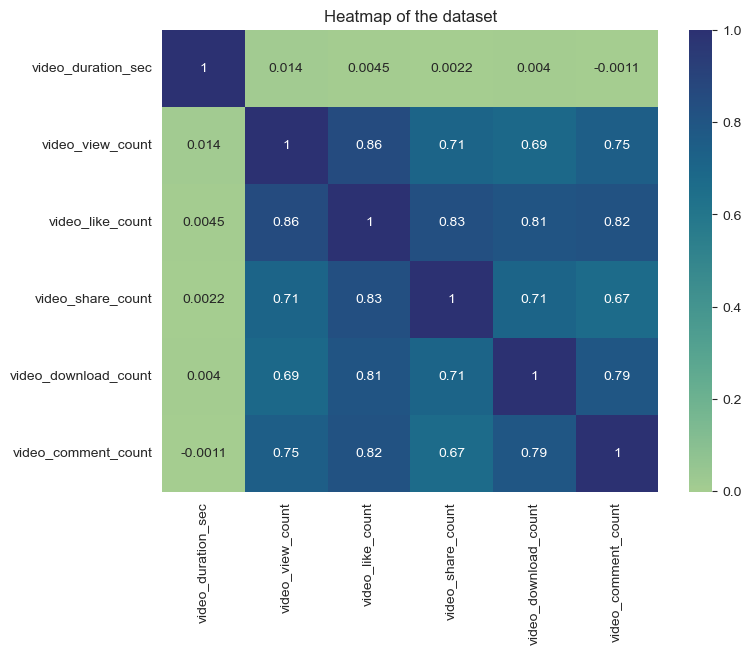

In [20]:
# Create a heatmap to visualize how correlated variables are

plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count"]]
    .corr(numeric_only=True), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

### <span style= 'color:red' > Transform categorical variables into numeric </span>

In [30]:
# Select the training features that needs to be encoded
data_upsampled_to_encode = data_upsampled[["claim_status", "author_ban_status"]]

# Display first few rows
data_upsampled_to_encode.head()

,claim_status,author_ban_status
0,claim,under review
1,claim,active
2,claim,active
3,claim,active
4,claim,active


In [31]:
# Set up an encoder for one-hot encoding the categorical features
data_upsampled_encoder = OneHotEncoder(drop='first', sparse_output=False)


# Fit and transform the training features using the encoder
data_upsampled_encoded = data_upsampled_encoder.fit_transform(data_upsampled_to_encode)


# Get feature names from encoder
data_upsampled_encoder.get_feature_names_out()


# Display first few rows of encoded training features
data_upsampled_encoded

array([[0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [32]:
# Place encoded training features (which is currently an array) into a dataframe
data_upsampled_encoded_df = pd.DataFrame(data=data_upsampled_encoded, columns=X_encoder.get_feature_names_out())

data_upsampled.drop(columns=["claim_status", "author_ban_status"])


data_upsampled_final = pd.concat([data_upsampled.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), data_upsampled_encoded_df], axis=1)

# Display first few rows
data_upsampled_final.head()

,#,video_id,video_duration_sec,video_transcription_text,verified_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1,7017666017,59,someone shared with me that drone deliveries a...,not verified,343296.0,19425.0,241.0,1.0,0.0,0.0,0.0,1.0
1,2,4014381136,32,someone shared with me that there are more mic...,not verified,140877.0,77355.0,19034.0,1161.0,684.0,0.0,0.0,0.0
2,3,9859838091,31,someone shared with me that american industria...,not verified,902185.0,97690.0,2858.0,833.0,329.0,0.0,0.0,0.0
3,4,1866847991,25,someone shared with me that the metro of st. p...,not verified,437506.0,239954.0,34812.0,1234.0,584.0,0.0,0.0,0.0
4,5,7105231098,19,someone shared with me that the number of busi...,not verified,56167.0,34987.0,4110.0,547.0,152.0,0.0,0.0,0.0


In [36]:
data_upsampled_final["verified_status"].value_counts()

not verified    17884
verified        17884
Name: verified_status, dtype: int64

### <span style= 'color:red' > Specify dependent and independents variables </span>

In [37]:
data_upsampled_final.head()

,#,video_id,video_duration_sec,video_transcription_text,verified_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1,7017666017,59,someone shared with me that drone deliveries a...,not verified,343296.0,19425.0,241.0,1.0,0.0,0.0,0.0,1.0
1,2,4014381136,32,someone shared with me that there are more mic...,not verified,140877.0,77355.0,19034.0,1161.0,684.0,0.0,0.0,0.0
2,3,9859838091,31,someone shared with me that american industria...,not verified,902185.0,97690.0,2858.0,833.0,329.0,0.0,0.0,0.0
3,4,1866847991,25,someone shared with me that the metro of st. p...,not verified,437506.0,239954.0,34812.0,1234.0,584.0,0.0,0.0,0.0
4,5,7105231098,19,someone shared with me that the number of busi...,not verified,56167.0,34987.0,4110.0,547.0,152.0,0.0,0.0,0.0


In [38]:
# select outcome variable

y = data_upsampled_final["verified_status"]


# select features
x = data_upsampled_final[["video_duration_sec", "video_view_count", "video_share_count",
                     "video_download_count", "video_comment_count", "claim_status_opinion",
                         "author_ban_status_banned", "author_ban_status_under review" ]]

x.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,241.0,1.0,0.0,0.0,0.0,1.0
1,32,140877.0,19034.0,1161.0,684.0,0.0,0.0,0.0
2,31,902185.0,2858.0,833.0,329.0,0.0,0.0,0.0
3,25,437506.0,34812.0,1234.0,584.0,0.0,0.0,0.0
4,19,56167.0,4110.0,547.0,152.0,0.0,0.0,0.0


In [39]:
# split the data into train and test sets

X_train, X_test , y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=0)


# get the shape of each
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((26826, 8), (8942, 8), (26826,), (8942,))

## Building model

In [48]:
# fit it to the training set

log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train ,y_train)


# predictions

y_pred = log_clf.predict(X_test)

### <span style= 'color:red' > Visualize model results </span>

<img src="images/value_10266329.png" width="100" height="100" align=left  >


## Part 4: Conclusion

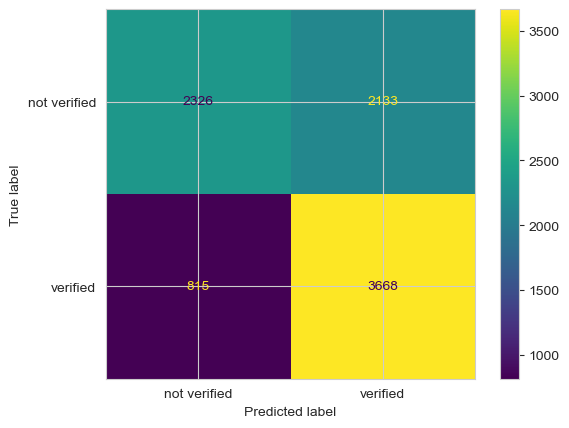

In [49]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [50]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.52      0.61      4459
not verified       0.63      0.82      0.71      4483

    accuracy                           0.67      8942
   macro avg       0.69      0.67      0.66      8942
weighted avg       0.69      0.67      0.66      8942



### <span style= 'color:red' > Model summary </span>

* Precision: How many of the predicted positives were actually correct? (74% for "verified" class)

* Recall: How many of the actual positives did the model capture? (82% for "not verified" class)

* F1-score: Harmonic mean of precision and recall, a balanced measure. (71% for "not verified" class)

### <span style= 'color:green' > The model seems to be performing better at predicting the "not verified" class. </span>

### <span style= 'color:royalblue' > The precision and recall scores are taken from the "not verified" row of the output are more important. Because that is the target class that we are most interested in predicting. </span>


* Business recommendations based on the model include strategies to encourage more opinion videos, such as incentivizing verified status or providing tools for expressing personal viewpoints. 
* Further analysis could explore factors influencing user verification and tailor content recommendations accordingly.


In [53]:
# the model coefficients

pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":log_clf.coef_[0]})

,Feature Name,Model Coefficient
0,video_duration_sec,-2.453752e-03
1,video_view_count,-1.688461e-07
2,video_share_count,4.826108e-06
3,video_download_count,-8.108662e-05
4,video_comment_count,4.482784e-04
5,claim_status_opinion,1.702603e+00
6,author_ban_status_banned,-4.484298e-01
7,author_ban_status_under review,-9.867234e-02
